In [1]:
# General libs
import os                             
import random 
from PIL import Image
import matplotlib.pyplot as plt     
%matplotlib inline   
from matplotlib.ticker import FuncFormatter
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
import pandas as pd             
import numpy as np  
!pip install opencv-python
import cv2                            

# ML libs
!pip install keras
!pip install tensorflow
import keras.backend as K
from keras import regularizers
from keras.models import Model, Sequential  
from keras.layers import Input, Flatten, Dropout, Dense, BatchNormalization
from keras.layers import LeakyReLU, PReLU, Activation, Conv2D, SeparableConv2D, MaxPool2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, History, EarlyStopping
import tensorflow as tf
tf.compat.v1.enable_eager_execution()
print(tf.executing_eagerly())

seed = 69
np.random.seed(seed)
tf.random.set_seed(seed)

Using TensorFlow backend.


True


In [2]:
input_path = './chest_xray/'

counter_normal_train = len(os.listdir(input_path + 'train' + '/NORMAL'))
counter_infect_train = len(os.listdir(input_path + 'train' + '/PNEUMONIA'))

counter_normal_test = len(os.listdir(input_path + 'test' + '/NORMAL'))
counter_infect_test = len(os.listdir(input_path + 'test' +  '/PNEUMONIA'))

counter_normal_val = len(os.listdir(input_path + 'val' + '/NORMAL'))
counter_infect_val = len(os.listdir(input_path + 'val' +  '/PNEUMONIA'))

counter_all = counter_normal_train + counter_infect_train + counter_normal_test + counter_infect_test + counter_normal_val +  counter_infect_val
counter_all_healthy = counter_normal_train + counter_normal_test + counter_normal_val
counter_all_infect = counter_infect_train + counter_infect_test + counter_infect_val

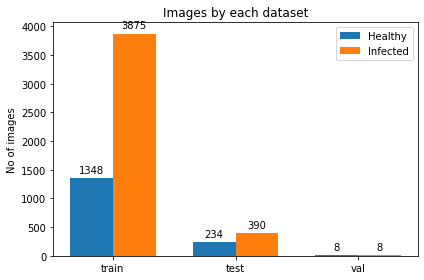

In [3]:
labels = ['train', 'test', 'val']
healthy_means = [counter_normal_train, counter_normal_test, counter_normal_val]
infected_means = [counter_infect_train, counter_infect_test, counter_infect_val]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, healthy_means, width, label='Healthy')
rects2 = ax.bar(x + width/2, infected_means, width, label='Infected')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('No of images')
ax.set_title('Images by each dataset')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

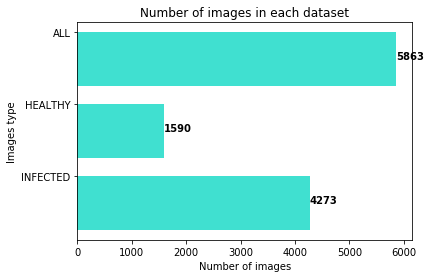

In [4]:
x = [u'INFECTED', u'HEALTHY', u'ALL']
y = [counter_all_infect, counter_all_healthy, counter_all]

fig, ax = plt.subplots()    
width = 0.75 # the width of the bars 
ind = np.arange(len(y))  # the x locations for the groups
ax.barh(ind, y, width, color="turquoise")
ax.set_yticks(ind+width/2)
ax.set_yticklabels(x, minor=False)
plt.title('Number of images in each dataset')
plt.xlabel('Number of images')
plt.ylabel('Images type')      
#plt.show()
plt.savefig(os.path.join('pneumonia_class.png'), dpi=400, format='png', bbox_inches='tight') 
# use format='svg' or 'pdf' for vectorial pictures

for i, v in enumerate(y):
    ax.text(v + 3, i, str(v), color='black', fontweight='bold')

In [5]:
def process_images(dimensions, batch):
  train_datagen =    ImageDataGenerator(rescale = 1./255, 
                                        zca_whitening=False, 
                                        horizontal_flip = False, 
                                        zoom_range = 0.5, 
                                        vertical_flip = True)
  test_val_datagen = ImageDataGenerator (rescale= 1./255)

  train_gen = train_datagen.flow_from_directory(directory = input_path + 'train', 
                                                target_size = (dimensions, dimensions), 
                                                batch_size = batch, 
                                                class_mode = 'binary', 
                                                shuffle = True)
  test_gen = test_val_datagen.flow_from_directory(directory = input_path + 'test', 
                                                  target_size = (dimensions, dimensions), 
                                                  batch_size = batch, 
                                                  class_mode = 'binary', 
                                                  shuffle = True)

  test_data = []
  test_labels = []

  for condition in ['/NORMAL/', '/PNEUMONIA/']:
    for image in (os.listdir(input_path + 'test' + condition)):
      image = plt.imread(input_path + 'test' + condition + image)
      image = cv2.resize(image, (dimensions, dimensions))
      image = np.dstack([image, image, image])
      image = image.astype('float32') / 255
      if condition == '/NORMAL/':
        label = 0
      elif condition == '/PNEUMONIA/':
        label = 1
        
      test_data.append(image)
      test_labels.append(label)

  test_data = np.array(test_data)
  test_labels = np.array(test_labels)

  return train_gen, test_gen, test_data, test_labels


In [6]:
dimensions = 150
epochs = 11
batch = 16

train_gen, test_gen, test_data, test_labels = process_images(dimensions, batch)

Found 5223 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [8]:
model = Sequential()
model.add(Conv2D(16, kernel_size=(3, 3), padding = 'same', input_shape=(150,150,3)))
model.add(Conv2D(16, kernel_size=(3, 3), padding = 'same'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(SeparableConv2D(32, kernel_size=(3, 3), padding = 'same'))
model.add(PReLU(alpha_initializer="zero"))
model.add(SeparableConv2D(32, kernel_size=(3, 3), padding = 'same'))
model.add(PReLU(alpha_initializer="zero"))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(SeparableConv2D(64, kernel_size=(3, 3), padding = 'same'))
model.add(PReLU(alpha_initializer="zero"))
model.add(SeparableConv2D(64, kernel_size=(3, 3), padding = 'same'))
model.add(PReLU(alpha_initializer="zero"))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(SeparableConv2D(128, kernel_size=(3, 3), padding = 'same'))
model.add(PReLU(alpha_initializer="zero"))
model.add(SeparableConv2D(128, kernel_size=(3, 3), padding = 'same'))
model.add(PReLU(alpha_initializer="zero"))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(SeparableConv2D(256, kernel_size=(3, 3), padding = 'same'))
model.add(PReLU(alpha_initializer="zero"))
model.add(SeparableConv2D(256, kernel_size=(3, 3), padding = 'same'))
model.add(PReLU(alpha_initializer="zero"))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(512, activation = 'relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.6))
model.add(Dense(128, activation = 'relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.4))
model.add(Dense(64, activation = 'relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.25))

model.add(Dense(1, activation = 'sigmoid', kernel_regularizer=regularizers.l2(0.01)))

# Creating a model and compiling
model.compile(optimizer = 'adam', 
              loss = 'binary_crossentropy', 
              metrics =['accuracy'])

# Callbacks
#tensor_board = TensorBoard(log_dir='graph.metrics', 
#                                           histogram_freq=0, 
#                                           write_graph=True, 
#                                           write_images=True)
checkpoint = ModelCheckpoint(filepath = 'weights.{epoch:02d}-{val_loss:.2f}.hdf5', 
                             verbose = 1,
                             mode = 'auto',
                             save_best_only=True, 
                             save_weights_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.3, 
                              patience=2, 
                              verbose=1)
history = History()

early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0.1, patience=3) #zca whitening and early stopping, change

In [9]:
hist = model.fit_generator(train_gen, 
                           steps_per_epoch = train_gen.samples // batch, 
                           epochs = epochs, 
                           validation_data = test_gen, 
                           validation_steps = test_gen.samples // batch, 
                           callbacks = [checkpoint, lr_reduce])


Epoch 1/11
326/326 [==============================] - 274s 842ms/step - loss: 1.1863 - accuracy: 0.8101 - val_loss: 0.8206 - val_accuracy: 0.6250

Epoch 00001: val_loss improved from inf to 0.82062, saving model to weights.01-0.82.hdf5
Epoch 2/11
326/326 [==============================] - 238s 731ms/step - loss: 0.4369 - accuracy: 0.8537 - val_loss: 0.7639 - val_accuracy: 0.6635

Epoch 00002: val_loss improved from 0.82062 to 0.76391, saving model to weights.02-0.76.hdf5
Epoch 3/11
326/326 [==============================] - 233s 716ms/step - loss: 0.3898 - accuracy: 0.8715 - val_loss: 0.5547 - val_accuracy: 0.7532

Epoch 00003: val_loss improved from 0.76391 to 0.55475, saving model to weights.03-0.55.hdf5
Epoch 4/11
326/326 [==============================] - 236s 724ms/step - loss: 0.3613 - accuracy: 0.8817 - val_loss: 0.4068 - val_accuracy: 0.8173

Epoch 00004: val_loss improved from 0.55475 to 0.40678, saving model to weights.04-0.41.hdf5
Epoch 5/11
326/326 [========================

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy', 'lr'])


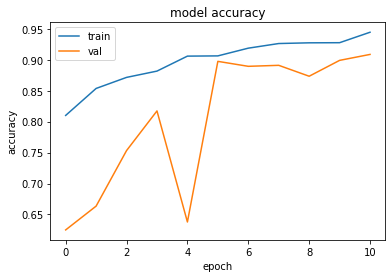

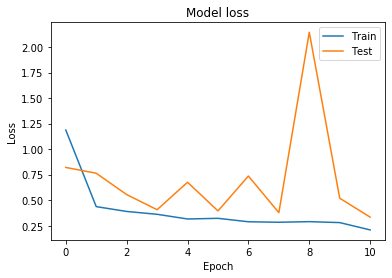

In [10]:
print(hist.history.keys())

plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'])
plt.show()

In [11]:
predict_probs = model.predict(test_data)
predict_classes = model.predict_classes(test_data, verbose=0)

predict_probs = predict_probs[:, 0]
predict_classes = predict_classes[:, 0]

print ('\nTest metrics\n----------------')
cm = confusion_matrix(test_labels, np.round(predict_probs))
print ('Confusion matrix\n', cm)
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(test_labels, predict_classes) * 100
print('Accuracy: {}%'.format(np.round(accuracy,2)))
# precision tp / (tp + fp)
precision = precision_score(test_labels, predict_classes) * 100
print('Precision: {}%'.format(np.round(precision,2)))
# recall: tp / (tp + fn)
recall = recall_score(test_labels, predict_classes) * 100
print('Recall: {}%'.format(np.round(recall,2)))
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(test_labels, predict_classes) * 100
print('F1-score: {}%'.format(np.round(2* precision * recall / (precision + recall),2)))

auc = roc_auc_score(test_labels, predict_probs)
print('ROC AUC: %f' % auc)

print('\nTrain metric\n----------------')
print('Train accuracy: {}'.format(np.round((hist.history['accuracy'][-1])*100, 2)))


Test metrics
----------------
Confusion matrix
 [[181  53]
 [  7 383]]
Accuracy: 90.38%
Precision: 87.84%
Recall: 98.21%
F1-score: 92.74%
ROC AUC: 0.952104

Train metric
----------------
Train accuracy: 94.45
